# Project 4 - Notebook 3 - Modelling (by Wilson Alberto Torres)

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, accuracy_score
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from IPython.display import display
from xgboost import XGBClassifier
import numpy as np
#!pip install eli5
import eli5
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from gensim import corpora, models, matutils
from collections import defaultdict
from nltk.corpus import stopwords

# Importing the cleaned dataset

In [9]:
# importing cleaned dataset, ready for modelling
result_df3 = pd.read_csv('jobs_project4-modelQ1.csv')

In [10]:
result_df3.head(2)

,job_id,s_keyword,job_title,city,job_type,job_field,job_subfield,range_sal,cleanedsalary,job_full_desc
0,50372185,data-analyst,Graduate Analyst Position - Melbourne,Melbourne,This is a Full Time job,Sales,Analysis & Reporting,30000-60000,50000,The Business Founded in this Australian owned...
1,50379232,data-analyst,Operations Analyst,Melbourne,This is a Full Time job,Insurance & Superannuation,Other,30000-60000,60000,Operations Analyst Drive the process improveme...


In [11]:
result_df3['cleanedsalary'].unique()

array([ 50000,  60000,  55000,  65325,  65000,  54000,  51000,  45000,
        85000,  40000, 100000,  85279,  98396,  80000,  90000,  70000,
        67195, 120000, 115000,  88004,  98744, 125000,  80669,  75000,
        69401, 105000,  93000,  95000,  86434,  86000,  96527, 101955,
        89314,  91250, 110000,  84930,  94471, 135000, 140000, 180000,
       150000, 116156, 160000, 130000, 188381, 165000, 200000, 137000,
       170000, 300000, 147804, 250000,  17000,  56000,  67000,  64000,
        58000,  29000,  79000,  63000,  63670,  35000,  12000, 107865,
        97000,  97152,  90743, 190000,  87000,  77000,  70146, 108147,
       109000,  93266, 109224,  98000,  79452,  82208,  82178,  73160,
        74233, 144126, 127559, 220000, 120200, 118015, 110745, 128089,
       113735, 240000, 108000, 125444, 145000, 127384, 124752, 155000,
        10000,  84279,  88994,  97812, 103409,  68000,  89766,  73000])

# Defining the predictor and the target variable

In [12]:
X = result_df3['job_full_desc'] # predictor
y = result_df3['cleanedsalary'] # label/target
print(f'Median: {y.median()}')

Median: 95000.0


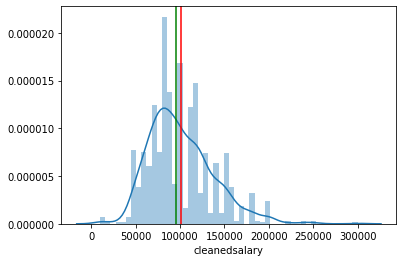

In [13]:
#y.plot(kind='density')
ax = sns.distplot(y, bins=50)
ax.axvline(y.mean(), color='r')
ax.axvline(y.median(), color='g')
#plt.show()

In [14]:
# The target variable is split (based on the median = '95000') in two low and high salary
y_class = pd.qcut(result_df3['cleanedsalary'],2).cat.codes

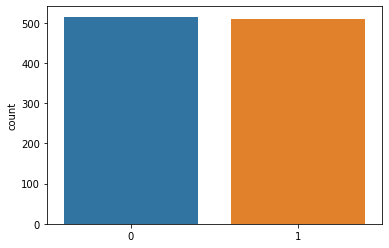

In [45]:
sns.countplot(y_class)

In [15]:
y_class

0       0
1       0
2       0
3       0
4       0
       ..
1020    1
1021    1
1022    1
1023    1
1024    1
Length: 1025, dtype: int8

In [16]:
y_class.shape

(1025,)

In [17]:
pd.Series(y_class).value_counts(normalize=True) # baseline

0    0.502439
1    0.497561
dtype: float64

In [18]:
y

0        50000
1        60000
2        55000
3        65325
4        55000
         ...  
1020    125000
1021    150000
1022    110745
1023    128089
1024    130000
Name: cleanedsalary, Length: 1025, dtype: int64

In [19]:
custom_stop_words = list(ENGLISH_STOP_WORDS)
X_train, X_test, y_train, y_test = train_test_split(X,y_class,random_state=42, stratify=y_class)

In [20]:
# This function receives a pipeline and will fit, predict and get the score of
# the analysed model. It will also print out the classification report, the
# confusion matrix, and the feature/varible importance.
def model_evaluation(pipeline_in):
    #scores = cross_val_score(pipeline_in, X, y_class)
    #print(f'Mean cross-val score: {scores.mean()}')
    #print(f'Standard deviation cross-val:{scores.std()}')
    
    pipeline_in.fit(X_train,y_train) # training the model
    pipeline_in.score(X_test,y_test) 
    y_hat_this = pipeline_in.predict(X_test)
    y_hat_pr_this = pipeline_in.predict_proba(X_test)
    print(f'Accuration score with y_test & y_pred: {accuracy_score(y_test,y_hat_this)}')
    print('----------------------------------------')
    print('Classification Report')
    print('----------------------------------------')
    print(classification_report(y_test,y_hat_this))
    
    print('----------------------------------------')
    print('Confusion Matrix')
    print('----------------------------------------')
    conmat = np.array(confusion_matrix(y_test,y_hat_this,labels=[1,0]))
    confusion = pd.DataFrame(conmat, index=['is_high_salary', 'is_low_salary'],
                         columns=['predicted_high_salary','predicted_low_salary'])
    print(confusion)
    
    fpr, tpr, th = roc_curve(y_test, y_hat_pr_this[:,1])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=[5,5])
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([-0.05, 1.0])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Receiver operating characteristic for DS salary', fontsize=12)
    plt.legend(loc="lower right")
    plt.show()
    
    display(eli5.explain_weights(pipeline_in))

# Experiment 1: Logistic Regression with full-job-description feature

In [21]:
# Creating the pipeline
pl_e1 = make_pipeline(CountVectorizer(stop_words=custom_stop_words, binary=True),LogisticRegression())
#pl_e1 = make_pipeline(TfidfVectorizer(), LogisticRegression())
lg_params = {'countvectorizer__min_df': (0.1, 0.2, 0.3),
             'countvectorizer__ngram_range': ((1, 1), (1, 2), (2,2)),
            'logisticregression__C':[100, 10, 1.0, 0.1, 0.01],
            'logisticregression__solver':['newton-cg', 'lbfgs', 'liblinear']}
lg_grid = GridSearchCV(pl_e1, param_grid=lg_params, cv=5, scoring="accuracy", n_jobs=-1)
lg_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(binary=True,
                                                        stop_words=['anyhow',
                                                                    'somehow',
                                                                    'former',
                                                                    'twenty',
                                                                    'themselves',
                                                                    'itself',
                                                                    'when',
                                                                    're', 'ten',
                                                                    'twelve',
                                                                    'no',
                                                                    'be

In [22]:
lg_best = lg_grid.best_score_
print(lg_grid.best_params_)
print(lg_grid.best_score_)
pl_e1.set_params(**lg_grid.best_params_)

{'countvectorizer__min_df': 0.1, 'countvectorizer__ngram_range': (1, 1), 'logisticregression__C': 0.01, 'logisticregression__solver': 'liblinear'}
0.7760376878023937


Pipeline(steps=[('countvectorizer',
                 CountVectorizer(binary=True, min_df=0.1,
                                 stop_words=['anyhow', 'somehow', 'former',
                                             'twenty', 'themselves', 'itself',
                                             'when', 're', 'ten', 'twelve',
                                             'no', 'beforehand', 'ourselves',
                                             'therein', 'again', 'about',
                                             'ever', 'seeming', 'their',
                                             'during', 'hundred', 'latter',
                                             'elsewhere', 'interest', 'two',
                                             'part', 'throughout', 'alone',
                                             'hereafter', 'yourselves', ...])),
                ('logisticregression',
                 LogisticRegression(C=0.01, solver='liblinear'))])

Accuration score with y_test & y_pred: 0.77431906614786
----------------------------------------
Classification Report
----------------------------------------
              precision    recall  f1-score   support

           0       0.75      0.82      0.79       129
           1       0.80      0.73      0.76       128

    accuracy                           0.77       257
   macro avg       0.78      0.77      0.77       257
weighted avg       0.78      0.77      0.77       257

----------------------------------------
Confusion Matrix
----------------------------------------
                predicted_high_salary  predicted_low_salary
is_high_salary                     93                    35
is_low_salary                      23                   106


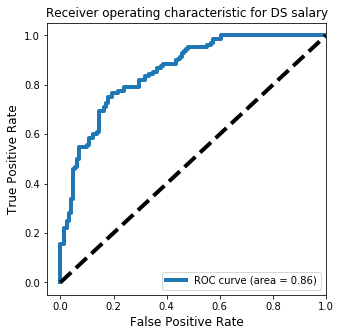

Weight?,Feature
+0.217,senior
+0.159,lead
+0.149,complex
+0.133,delivery
+0.127,stakeholders
+0.113,risk
+0.113,leadership
+0.112,highly
+0.112,build
+0.110,engineer


In [23]:
model_evaluation(pl_e1)

# Experiment 2: Random Forest Classifier with job-full-description feature

In [24]:
pl_e3 = make_pipeline(CountVectorizer(stop_words=custom_stop_words, binary=True), 
                                RandomForestClassifier())

lg_params3 = {'countvectorizer__min_df': (0.1, 0.2, 0.3),
             'countvectorizer__ngram_range': ((1, 1), (1, 2), (2,2)),
             'randomforestclassifier__max_depth': [10, 20, 30, 40],
             'randomforestclassifier__min_samples_leaf': [1, 2, 4],
             'randomforestclassifier__n_estimators': [400, 600, 800]}
lg_grid3 = GridSearchCV(pl_e3, param_grid=lg_params3, cv=5, scoring="accuracy", n_jobs=-1)
lg_grid3.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(binary=True,
                                                        stop_words=['anyhow',
                                                                    'somehow',
                                                                    'former',
                                                                    'twenty',
                                                                    'themselves',
                                                                    'itself',
                                                                    'when',
                                                                    're', 'ten',
                                                                    'twelve',
                                                                    'no',
                                                                    'be

In [25]:
rfc_best = lg_grid3.best_score_
print(lg_grid3.best_params_)
print(lg_grid3.best_score_)
pl_e3.set_params(**lg_grid3.best_params_)

{'countvectorizer__min_df': 0.1, 'countvectorizer__ngram_range': (1, 2), 'randomforestclassifier__max_depth': 40, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__n_estimators': 600}
0.803335879806468


Pipeline(steps=[('countvectorizer',
                 CountVectorizer(binary=True, min_df=0.1, ngram_range=(1, 2),
                                 stop_words=['anyhow', 'somehow', 'former',
                                             'twenty', 'themselves', 'itself',
                                             'when', 're', 'ten', 'twelve',
                                             'no', 'beforehand', 'ourselves',
                                             'therein', 'again', 'about',
                                             'ever', 'seeming', 'their',
                                             'during', 'hundred', 'latter',
                                             'elsewhere', 'interest', 'two',
                                             'part', 'throughout', 'alone',
                                             'hereafter', 'yourselves', ...])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=40, n_estimators=600))])

Accuration score with y_test & y_pred: 0.8015564202334631
----------------------------------------
Classification Report
----------------------------------------
              precision    recall  f1-score   support

           0       0.77      0.85      0.81       129
           1       0.83      0.75      0.79       128

    accuracy                           0.80       257
   macro avg       0.80      0.80      0.80       257
weighted avg       0.80      0.80      0.80       257

----------------------------------------
Confusion Matrix
----------------------------------------
                predicted_high_salary  predicted_low_salary
is_high_salary                     96                    32
is_low_salary                      19                   110


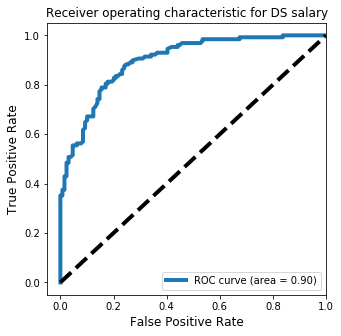

Weight,Feature
0.0168 ± 0.0416,senior
0.0142 ± 0.0375,attention
0.0126 ± 0.0351,time
0.0111 ± 0.0323,office
0.0101 ± 0.0314,social
0.0089 ± 0.0250,complex
0.0075 ± 0.0253,tasks
0.0066 ± 0.0202,customer
0.0065 ± 0.0196,lead
0.0064 ± 0.0218,sales


In [26]:
model_evaluation(pl_e3)

# Experiment 3: KNN - with full-job-description feature

In [28]:
# Creating the pipeline
pl_e5 = make_pipeline(CountVectorizer(stop_words=custom_stop_words,binary=True), 
                      KNeighborsClassifier())

lg_params5 = {'countvectorizer__min_df': (0.1, 0.2, 0.3),
             'countvectorizer__ngram_range': ((1, 1), (1, 2), (2,2)),
             'kneighborsclassifier__n_neighbors': [3, 5, 7, 9, 11],
             'kneighborsclassifier__weights': ['uniform', 'distance'],
             'kneighborsclassifier__metric': ['euclidean', 'manhattan']}
lg_grid5 = GridSearchCV(pl_e5, param_grid=lg_params5, cv=5, scoring="accuracy", n_jobs=-1)
lg_grid5.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(binary=True,
                                                        stop_words=['anyhow',
                                                                    'somehow',
                                                                    'former',
                                                                    'twenty',
                                                                    'themselves',
                                                                    'itself',
                                                                    'when',
                                                                    're', 'ten',
                                                                    'twelve',
                                                                    'no',
                                                                    'be

In [31]:
knn_best = lg_grid5.best_score_
print(lg_grid5.best_params_)
print(lg_grid5.best_score_)
pl_e5.set_params(**lg_grid5.best_params_)

{'countvectorizer__min_df': 0.1, 'countvectorizer__ngram_range': (1, 2), 'kneighborsclassifier__metric': 'euclidean', 'kneighborsclassifier__n_neighbors': 11, 'kneighborsclassifier__weights': 'distance'}
0.7277905101434513


Pipeline(steps=[('countvectorizer',
                 CountVectorizer(binary=True, min_df=0.1, ngram_range=(1, 2),
                                 stop_words=['anyhow', 'somehow', 'former',
                                             'twenty', 'themselves', 'itself',
                                             'when', 're', 'ten', 'twelve',
                                             'no', 'beforehand', 'ourselves',
                                             'therein', 'again', 'about',
                                             'ever', 'seeming', 'their',
                                             'during', 'hundred', 'latter',
                                             'elsewhere', 'interest', 'two',
                                             'part', 'throughout', 'alone',
                                             'hereafter', 'yourselves', ...])),
                ('kneighborsclassifier',
                 KNeighborsClassifier(metric='euclidean', n_neighbors=11,
      

Accuration score with y_test & y_pred: 0.7392996108949417
----------------------------------------
Classification Report
----------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.62      0.70       129
           1       0.69      0.86      0.77       128

    accuracy                           0.74       257
   macro avg       0.75      0.74      0.74       257
weighted avg       0.75      0.74      0.74       257

----------------------------------------
Confusion Matrix
----------------------------------------
                predicted_high_salary  predicted_low_salary
is_high_salary                    110                    18
is_low_salary                      49                    80


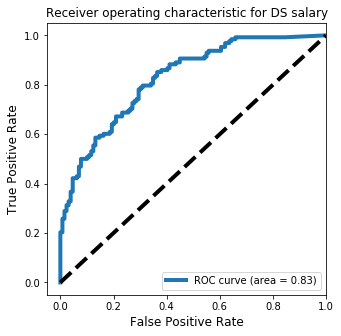

Explanation(estimator="Pipeline(steps=[('countvectorizer',\n                 CountVectorizer(binary=True, min_df=0.1, ngram_range=(1, 2),\n                                 stop_words=['anyhow', 'somehow', 'former',\n                                             'twenty', 'themselves', 'itself',\n                                             'when', 're', 'ten', 'twelve',\n                                             'no', 'beforehand', 'ourselves',\n                                             'therein', 'again', 'about',\n                                             'ever', 'seeming', 'their',\n                                             'during', 'hundred', 'latter',\n                                             'elsewhere', 'interest', 'two',\n                                             'part', 'throughout', 'alone',\n                                             'hereafter', 'yourselves', ...])),\n                ('kneighborsclassifier',\n                 KNeighborsClassifier(metric='euclidean', n_neighbors=11,\n                                      weights='distance'))])", description=None, error="estimator KNeighborsClassifier(metric='euclidean', n_neighbors=11, weights='distance') is not supported", method=None, is_regression=False, targets=None, feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

In [32]:
model_evaluation(pl_e5)

# Experiment 4: SVM - with full-job-description feature

In [33]:
# Creating the pipeline
pl_e6 = make_pipeline(CountVectorizer(stop_words=custom_stop_words,binary=True), SVC(probability=True))

lg_params6 = {'countvectorizer__min_df': (0.1, 0.2, 0.3),
             'countvectorizer__ngram_range': ((1, 1), (1, 2), (2,2)),
             'svc__C': [0.1, 1, 10, 100, 1000],
             'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001]}
lg_grid6 = GridSearchCV(pl_e6, param_grid=lg_params6, cv=5, scoring="accuracy", n_jobs=-1)
lg_grid6.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(binary=True,
                                                        stop_words=['anyhow',
                                                                    'somehow',
                                                                    'former',
                                                                    'twenty',
                                                                    'themselves',
                                                                    'itself',
                                                                    'when',
                                                                    're', 'ten',
                                                                    'twelve',
                                                                    'no',
                                                                    'be

In [34]:
svm_best = lg_grid6.best_score_
print(lg_grid6.best_params_)
print(lg_grid6.best_score_)
pl_e6.set_params(**lg_grid6.best_params_)

{'countvectorizer__min_df': 0.1, 'countvectorizer__ngram_range': (1, 1), 'svc__C': 1, 'svc__gamma': 0.01}
0.8033783210253798


Pipeline(steps=[('countvectorizer',
                 CountVectorizer(binary=True, min_df=0.1,
                                 stop_words=['anyhow', 'somehow', 'former',
                                             'twenty', 'themselves', 'itself',
                                             'when', 're', 'ten', 'twelve',
                                             'no', 'beforehand', 'ourselves',
                                             'therein', 'again', 'about',
                                             'ever', 'seeming', 'their',
                                             'during', 'hundred', 'latter',
                                             'elsewhere', 'interest', 'two',
                                             'part', 'throughout', 'alone',
                                             'hereafter', 'yourselves', ...])),
                ('svc', SVC(C=1, gamma=0.01, probability=True))])

Accuration score with y_test & y_pred: 0.7898832684824902
----------------------------------------
Classification Report
----------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.81      0.79       129
           1       0.80      0.77      0.79       128

    accuracy                           0.79       257
   macro avg       0.79      0.79      0.79       257
weighted avg       0.79      0.79      0.79       257

----------------------------------------
Confusion Matrix
----------------------------------------
                predicted_high_salary  predicted_low_salary
is_high_salary                     99                    29
is_low_salary                      25                   104


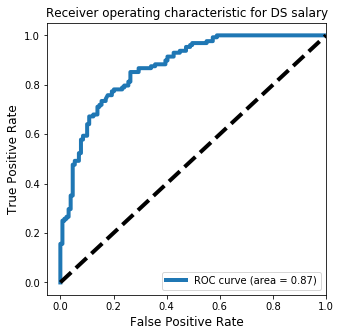

Explanation(estimator="Pipeline(steps=[('countvectorizer',\n                 CountVectorizer(binary=True, min_df=0.1,\n                                 stop_words=['anyhow', 'somehow', 'former',\n                                             'twenty', 'themselves', 'itself',\n                                             'when', 're', 'ten', 'twelve',\n                                             'no', 'beforehand', 'ourselves',\n                                             'therein', 'again', 'about',\n                                             'ever', 'seeming', 'their',\n                                             'during', 'hundred', 'latter',\n                                             'elsewhere', 'interest', 'two',\n                                             'part', 'throughout', 'alone',\n                                             'hereafter', 'yourselves', ...])),\n                ('svc', SVC(C=1, gamma=0.01, probability=True))])", description=None, error="only kernel='linear' is currently supported for libsvm-based classifiers", method=None, is_regression=False, targets=None, feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

In [35]:
model_evaluation(pl_e6)

# Experiment 5: Ensemble - AdaBoostClassifier

In [36]:
# Creating the pipeline
pl_e7 = make_pipeline(CountVectorizer(stop_words=custom_stop_words,binary=True), 
                         AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1)))

lg_params7 = {'countvectorizer__min_df': (0.1, 0.2, 0.3),
             'countvectorizer__ngram_range': ((1, 1), (1, 2), (2,2)),
             'adaboostclassifier__n_estimators': [100, 200],
             'adaboostclassifier__learning_rate': [0.001, 0.01, 0.1, 0.2, 0.5]}
lg_grid7 = GridSearchCV(pl_e7, param_grid=lg_params7, cv=5, scoring="accuracy", n_jobs=-1)
lg_grid7.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(binary=True,
                                                        stop_words=['anyhow',
                                                                    'somehow',
                                                                    'former',
                                                                    'twenty',
                                                                    'themselves',
                                                                    'itself',
                                                                    'when',
                                                                    're', 'ten',
                                                                    'twelve',
                                                                    'no',
                                                                    'be

In [37]:
AdaBoost_best = lg_grid7.best_score_
print(lg_grid7.best_params_)
print(lg_grid7.best_score_)
pl_e7.set_params(**lg_grid7.best_params_)

{'adaboostclassifier__learning_rate': 0.5, 'adaboostclassifier__n_estimators': 100, 'countvectorizer__min_df': 0.1, 'countvectorizer__ngram_range': (1, 2)}
0.7512265512265512


Pipeline(steps=[('countvectorizer',
                 CountVectorizer(binary=True, min_df=0.1, ngram_range=(1, 2),
                                 stop_words=['anyhow', 'somehow', 'former',
                                             'twenty', 'themselves', 'itself',
                                             'when', 're', 'ten', 'twelve',
                                             'no', 'beforehand', 'ourselves',
                                             'therein', 'again', 'about',
                                             'ever', 'seeming', 'their',
                                             'during', 'hundred', 'latter',
                                             'elsewhere', 'interest', 'two',
                                             'part', 'throughout', 'alone',
                                             'hereafter', 'yourselves', ...])),
                ('adaboostclassifier',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_dept

Accuration score with y_test & y_pred: 0.7859922178988327
----------------------------------------
Classification Report
----------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.78      0.79       129
           1       0.78      0.79      0.79       128

    accuracy                           0.79       257
   macro avg       0.79      0.79      0.79       257
weighted avg       0.79      0.79      0.79       257

----------------------------------------
Confusion Matrix
----------------------------------------
                predicted_high_salary  predicted_low_salary
is_high_salary                    101                    27
is_low_salary                      28                   101


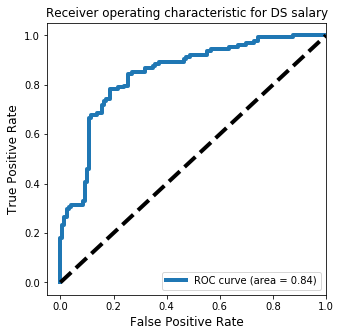

Weight,Feature
0.0300 ± 0.3412,lead
0.0300 ± 0.3412,decisions
0.0200 ± 0.2800,analysis
0.0200 ± 0.2800,social
0.0200 ± 0.2800,complex
0.0200 ± 0.2800,time
0.0200 ± 0.2800,proven
0.0200 ± 0.2800,office
0.0200 ± 0.2800,melbourne
0.0200 ± 0.2800,customer


In [38]:
model_evaluation(pl_e7)

# Experiment 6: Ensemble - XGBoost 

In [112]:
# https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier

In [39]:
# Creating the pipeline
pl_e8 = make_pipeline(CountVectorizer(stop_words=custom_stop_words,binary=True),XGBClassifier())

lg_params8 = {'countvectorizer__min_df': (0.1, 0.2, 0.3),
             'countvectorizer__ngram_range': ((1, 1), (1, 2), (2,2)),
             'xgbclassifier__n_estimators': [400, 700, 1000],
             'xgbclassifier__max_depth': [15,20,25],
             'xgbclassifier__reg_alpha': [1.1, 1.2, 1.3],
             'xgbclassifier__reg_lambda': [1.1, 1.2, 1.3]}
lg_grid8 = GridSearchCV(pl_e8, param_grid=lg_params8, cv=5, scoring="accuracy", n_jobs=1)
lg_grid8.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(binary=True,
                                                        stop_words=['anyhow',
                                                                    'somehow',
                                                                    'former',
                                                                    'twenty',
                                                                    'themselves',
                                                                    'itself',
                                                                    'when',
                                                                    're', 'ten',
                                                                    'twelve',
                                                                    'no',
                                                                    'be

In [40]:
AdaBoost_best = lg_grid8.best_score_
print(lg_grid8.best_params_)
print(lg_grid8.best_score_)
pl_e8.set_params(**lg_grid8.best_params_)

{'countvectorizer__min_df': 0.1, 'countvectorizer__ngram_range': (1, 1), 'xgbclassifier__max_depth': 15, 'xgbclassifier__n_estimators': 400, 'xgbclassifier__reg_alpha': 1.1, 'xgbclassifier__reg_lambda': 1.2}
0.78774297597827


Pipeline(steps=[('countvectorizer',
                 CountVectorizer(binary=True, min_df=0.1,
                                 stop_words=['anyhow', 'somehow', 'former',
                                             'twenty', 'themselves', 'itself',
                                             'when', 're', 'ten', 'twelve',
                                             'no', 'beforehand', 'ourselves',
                                             'therein', 'again', 'about',
                                             'ever', 'seeming', 'their',
                                             'during', 'hundred', 'latter',
                                             'elsewhere', 'interest', 'two',
                                             'part', 'throughout', 'alone',
                                             'hereafter',...
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=None,
                        

Accuration score with y_test & y_pred: 0.8015564202334631
----------------------------------------
Classification Report
----------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.84      0.81       129
           1       0.82      0.77      0.79       128

    accuracy                           0.80       257
   macro avg       0.80      0.80      0.80       257
weighted avg       0.80      0.80      0.80       257

----------------------------------------
Confusion Matrix
----------------------------------------
                predicted_high_salary  predicted_low_salary
is_high_salary                     98                    30
is_low_salary                      21                   108


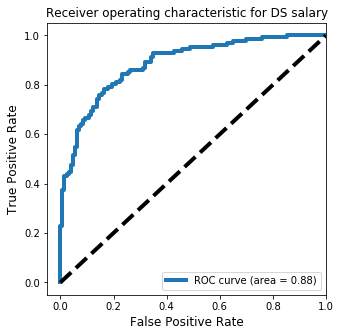

Weight,Feature
0.0206,committed
0.0180,senior
0.0151,complex
0.0149,existing
0.0142,profile
0.0121,teams
0.0116,office
0.0107,closely
0.0107,attention
0.0104,manager


In [41]:
model_evaluation(pl_e8)

# Experiment 7: Ensemble - Gradient Boosting Classifier

In [42]:
# Creating the pipeline
pl_e9 = make_pipeline(CountVectorizer(stop_words=custom_stop_words,binary=True),
                         GradientBoostingClassifier(n_estimators=50,learning_rate=1.0,
                                                    max_depth=4))

lg_params9 = {'countvectorizer__min_df': (0.1, 0.2, 0.3),
             'countvectorizer__ngram_range': ((1,1), (1,2), (2,2)),
             'gradientboostingclassifier__n_estimators': [50,100,150],
             'gradientboostingclassifier__max_depth': [4,6,8]}
lg_grid9 = GridSearchCV(pl_e9, param_grid=lg_params9, cv=5, scoring="accuracy", n_jobs=-1)
lg_grid9.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(binary=True,
                                                        stop_words=['anyhow',
                                                                    'somehow',
                                                                    'former',
                                                                    'twenty',
                                                                    'themselves',
                                                                    'itself',
                                                                    'when',
                                                                    're', 'ten',
                                                                    'twelve',
                                                                    'no',
                                                                    'be

In [43]:
Gradient_boosting_best = lg_grid9.best_score_
print(lg_grid9.best_params_)
print(lg_grid9.best_score_)
pl_e9.set_params(**lg_grid9.best_params_)

{'countvectorizer__min_df': 0.1, 'countvectorizer__ngram_range': (1, 1), 'gradientboostingclassifier__max_depth': 8, 'gradientboostingclassifier__n_estimators': 100}
0.7773363891010949


Pipeline(steps=[('countvectorizer',
                 CountVectorizer(binary=True, min_df=0.1,
                                 stop_words=['anyhow', 'somehow', 'former',
                                             'twenty', 'themselves', 'itself',
                                             'when', 're', 'ten', 'twelve',
                                             'no', 'beforehand', 'ourselves',
                                             'therein', 'again', 'about',
                                             'ever', 'seeming', 'their',
                                             'during', 'hundred', 'latter',
                                             'elsewhere', 'interest', 'two',
                                             'part', 'throughout', 'alone',
                                             'hereafter', 'yourselves', ...])),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=8))])

Accuration score with y_test & y_pred: 0.7704280155642024
----------------------------------------
Classification Report
----------------------------------------
              precision    recall  f1-score   support

           0       0.73      0.87      0.79       129
           1       0.83      0.67      0.74       128

    accuracy                           0.77       257
   macro avg       0.78      0.77      0.77       257
weighted avg       0.78      0.77      0.77       257

----------------------------------------
Confusion Matrix
----------------------------------------
                predicted_high_salary  predicted_low_salary
is_high_salary                     86                    42
is_low_salary                      17                   112


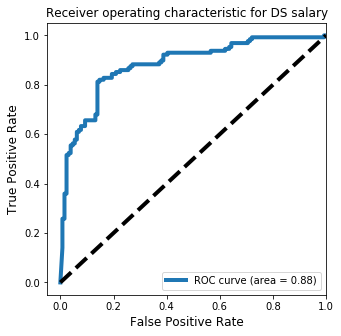

Weight,Feature
0.0565 ± 0.0202,senior
0.0419 ± 0.1397,candidates
0.0392 ± 0.6494,python
0.0389 ± 0.6323,work
0.0336 ± 0.0120,office
0.0316 ± 0.5774,engineer
0.0299 ± 0.5899,technical
0.0285 ± 0.0093,complex
0.0213 ± 0.0080,time
0.0209 ± 0.0077,sales


In [44]:
model_evaluation(pl_e9)